In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# импорты

warnings.filterwarnings('ignore')
# если это прописать, то фигня в виде предупреждений не будет высвечиваться

In [3]:
bd = pd.read_csv('final.csv')
# ем базу данных

bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])
# время звонка было дано в типе строки, поэтому стоит изменить тип данных на datetime 

bd['age'] = bd['age'].str.replace(',', '.').astype(float)
# возраст также был дан в типе строки, причем с разделителем - запятой (там все строки были по типу 38,0), поэтому сначала заменяю все запятые на точку, потому делаю тип данных float 

bd['flag'] = (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно')
# работать с 'Дозвон, Успешно' не очень удобно, поэтому я создал столбец flag, который равен True, если (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно') и False - иначе

bd['flag'] = bd['flag'].astype(int)
# но работать с True и False тоже не оч удобно, поэтому делаю тип данных int, то есть меняю True на 1, False - на 0. 

days_of_week = bd['finish_dttm'].dt.day_name()
bd['day_of_week'] = days_of_week
# когда-то у нас была гипотеза, связанная с днями неделями, для этого я создал столбец day_of_week

days_of_week_num = bd['finish_dttm'].dt.weekday
bd['num_of_week'] = days_of_week_num
# но есть проблема - питон сортирует строки в лексикографическом порядке (то есть так: Вс Вт Пн Пт Сб Ср Чт), а удобнее работать когда сортировка идет по порядку (то есть Пн, Вт, Ср и тд), поэтому я создал столбец num_of_week - номер дня недели, где 0 - Понедельник, 6 - Воскресенье

def vibrosi(bd, i, x):
    return pd.concat([bd[bd[i] < x], bd[bd[i].isna()]])
# для удобства чистки выбросов написал функцию, которая оставляет в столбце i только те значения, которые МЕНЬШЕ x (+ наны)

def vibrosiVniz(bd, i, x):
    return pd.concat([bd[bd[i] > x], bd[bd[i].isna()]])
# для удобства чистки выбросов написал функцию, которая оставляет в столбце i только те значения, которые БОЛЬШЕ x (+ наны)

bd['child_flg'] = bd['child_amt'] != 0
bd['child_flg'] = bd['child_flg'].astype(int)
# создал флаг наличия детей

bd = vibrosi(bd, 'confirmed_income', 10000000)
bd = vibrosi(bd, 'predicted_income', 10000000)
bd = vibrosiVniz(bd, 'predicted_income', 0)
bd = vibrosiVniz(bd, 'age', 17)
# та самая чистка выбросов (и кстати я все это время вас обманывал, у нас не было чистки по времени звонка)

df = bd.drop(bd[bd['wo_hit_status_reason_desc'].isin(['Отказ прослушать предложение', 'Не звонить', 'Левый контакт', 'Отказ от диалога', 'отказ от диалога', 'Отказ от разговора', 'Не звонить, резкий негатив', 'Негатив/Не звонить', 'Отказ без объяснения причин', 'просит не звонить', 'Не звонить / резкий негатив', 'Вежливо попросил не звонить', 'Номер не принадлежит страхователю', 'отказ без объяснения причин', 'Отказался озвучить причину', 'Чёрный список', 'негатив к Тинькофф', 'Грубо попросил не звонить', 'Не звонить (негатив)', 'Отказался от диалога', 'Просит больше не звонить', 'Недозвон', 'некорректная заявка', 'Техническая ошибка', 'Не нравится Т-Банк', 'Негатив к Т-Банку', 'Негативная информация о клиенте', 'Отказ без объяснения причины', 'Неизвестен / Не контактирует', 'Человек не участвовал в Дано', 'отменили'])].index)
# та самая обработка датасета по причинам звонка

df['income'] = df['confirmed_income'].fillna(df['predicted_income'])
# создал стобец который хранит значения confirmed_income, если они не NaN, иначе - predicted_income

df['segment_number'] = df['segment_cd'].str.extract(r'\((\d+)\)').astype(float)
# нам был дан уникальный номер сегмента - создал segment_number 

df['num_segment'] = (df['segment_cd'].str[2:4])
df['num_segment'] = df['num_segment'].astype(float)
# те самые сегменты от 1 до 12, создал num_segment

# Извлекаем номер месяца
df['month'] = df['finish_dttm'].dt.month

# Извлекаем час звонка
df['hours'] = df['finish_dttm'].dt.hour

# Функция для определения сезона по номеру месяца
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10, 11]:
        return 'Осень'
# Применяем функцию для создания нового столбца season
df['season'] = df['month'].apply(get_season)

df = vibrosi(df, 'hours', 21)
df = vibrosiVniz(df, 'hours', 6)
# еще чистка

In [5]:
emp = df[['employee_id', 'emp_age', 'emp_age_new', 'emp_gender_cd', 'emp_children_cnt', 'emp_work_months_cnt', 'state_talk_time_sec', 'flag']].groupby(by=['employee_id', 'emp_gender_cd']).mean()
# для работы с операторами создал отдельный датафрейм emp, где строка - один оператор и инфа о нем

emp.reset_index(inplace=True)
# восстановил индексы в отдельную колонку

emp['time_uspeh'] = 0
def ok(id):
    return df[df['flag'] == 1][df['employee_id'] == id]['state_talk_time_sec'].mean()
emp['time_uspeh'] = emp['employee_id'].apply(ok)
# создал столбец, который показывает среднее время успешного звонка для каждого оператора

# 1. Считаем успешность по employee_id и gender_cd
success_rates = (
    df.groupby(['employee_id', 'gender_cd'])['flag']
    .mean()
    .reset_index()
    .rename(columns={'flag': 'success_rate'})
)

# 2. Для каждого employee_id выбираем gender_cd с максимальной успешностью
best_gender_per_employee = (
    success_rates.loc[success_rates.groupby('employee_id')['success_rate'].idxmax()]
    [['employee_id', 'gender_cd']]
    .rename(columns={'gender_cd': 'lovely_gender_cd'})
)

# мержу
emp = emp.merge(best_gender_per_employee, on='employee_id', how='left')

# Рассчитываем процент успешности по каждому оператору и продукту
success_rate = df[['employee_id', 'product_cd', 'flag']].groupby(['employee_id', 'product_cd'])['flag'].mean().reset_index()
success_rate.rename(columns={'flag': 'success_rate'}, inplace=True)

# Для каждого оператора выбираем продукт с наибольшим процентом успешности
best_product = success_rate.loc[success_rate.groupby('employee_id')['success_rate'].idxmax()]

# Добавляем столбец best_product в emp
emp = emp.merge(best_product[['employee_id', 'product_cd']], on='employee_id', how='left')
emp.rename(columns={'product_cd': 'best_product'}, inplace=True)

emp = emp.rename({'flag' : 'emp_mean_flag'}, axis=1)
# я хочу создать df_plus_emp (который кстати потом в итоге у нас будет итоговым датасетом) и чтобы не мержить датасеты с одинаковыми названиями столбцом нужно чучуть переименовать

# мержу df и emp по employee_id
df_plus_emp = df.merge(emp[['employee_id', 'emp_mean_flag', 'time_uspeh', 'lovely_gender_cd', 'best_product']], on='employee_id', how='left')

# совпадение женского гендера
df_plus_emp['female_matching'] = ((df_plus_emp['gender_cd'] == 'F') & (df_plus_emp['emp_gender_cd'] == 'W')).astype(int)

# совпадение мужского гендера
df_plus_emp['male_matching'] = ((df_plus_emp['gender_cd'] == 'M') & (df_plus_emp['emp_gender_cd'] == 'M')).astype(int)

# просто совпадение гендера
df_plus_emp['gender_matching'] = ((df_plus_emp['female_matching'] == 1) | (df_plus_emp['male_matching'] == 1)).astype(int)

# создал age_matching, который равен 1, если разница возростов у оператора и клиента не больше 5 лет
df_plus_emp['age_matching'] = ((df_plus_emp['age'] - df_plus_emp['emp_age']).abs() <= 5).astype(int)

# работать с M и F чучуть неудобно, поэтому декодирую (М -> 1, F -> 0)
df_plus_emp['lovely_gender_cd_encoded'] = (df_plus_emp['lovely_gender_cd'] == 'M').astype(int)

# child_by_emp_and_cd_flg - флаг того, что и у оператора, и у клиента есть дети
df_plus_emp['child_by_emp_and_cd_flg'] = ((df_plus_emp['child_amt'] > 0) * (df_plus_emp['emp_children_cnt'] > 0)).astype(int)

# функа для деления на возрастные группы
def sha_budet_rok(x):
    if x <= 22:
        return '18-22'
    elif x <= 40:
        return '23-40'
    elif x <= 60:
        return '41-60'
    elif x <= 80:
        return '61-80'
    else:
        return '80-85'

# лиза просто запуталась в обозначениях)
def liza_prosto_zaputalas_v_oboznacheniyah(x):
    if x == 1:
        return 'Гендеры совпадают'
    if x == 0:
        return 'Гендеры разные'

# присваиваю клиентам возрастные группы
df_plus_emp['age_groups_cd'] = df_plus_emp['age'].apply(lambda x: sha_budet_rok(x))

# присваиваю клиентам возрастные группы
df_plus_emp['age_groups_emp'] = df_plus_emp['emp_age_new'].apply(lambda x: sha_budet_rok(x))

# СОЗДАЮ age_group_matching
df_plus_emp['age_group_matching'] = (df_plus_emp['age_groups_cd'] == df_plus_emp['age_groups_emp']).astype(int)

# это чтобы лиза не путалась в обозначениях
df_plus_emp['pol_sovpadenie'] = df_plus_emp['gender_matching'].apply(lambda x: liza_prosto_zaputalas_v_oboznacheniyah(x))

In [6]:
# Функция для получения нижней границы группы
def extract_min_age(group):
    return int(group.split('-')[0])

# Преобразуем группы в числовые значения (нижняя граница)
df_plus_emp['emp_group_min'] = df_plus_emp['age_groups_emp'].apply(extract_min_age)
df_plus_emp['client_group_min'] = df_plus_emp['age_groups_cd'].apply(extract_min_age)

# ТОТ САМЫЙ МЭТЧИНГ ВАРИАНС
df_plus_emp['matching_variance'] = np.where(df_plus_emp['emp_group_min'] > df_plus_emp['client_group_min'], 'Оператор старше клиента',
                                   np.where(df_plus_emp['emp_group_min'] == df_plus_emp['client_group_min'], 'Одинаковый возраст', 'Клиент старше операторa'))

# Удаляем временные столбцы, они не нужны
df_plus_emp.drop(['emp_group_min', 'client_group_min'], axis=1, inplace=True)

# все, на этом обработка датасета кончается

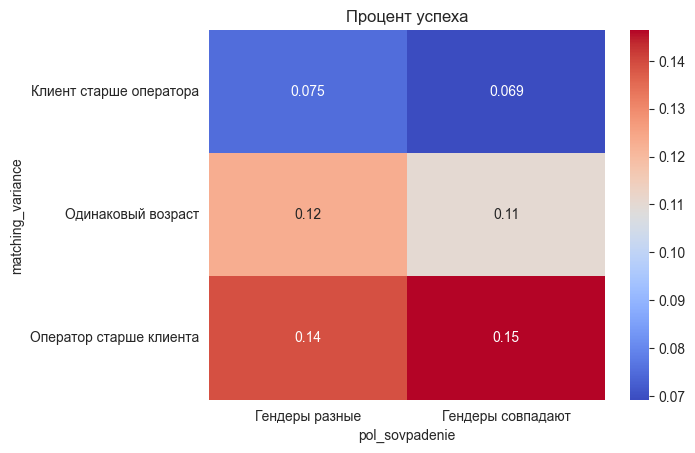

In [7]:
# Выделяю только кредитные карты
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()

# создаю сводную таблицу, где строки - мэтчинг варианс, столбцы - совпадение гендеров, значение - средняя успешность для этих условий 
pivot = cc.pivot_table(index='matching_variance' , values='flag', columns='pol_sovpadenie', aggfunc='mean')

# делаю хитмапу по сводной таблице, cmap - цвета, в которых делать
sns.heatmap(pivot, annot=True, cmap='coolwarm')

plt.title('Процент успеха')
plt.show()

Помнишь эту хитмапу?) (скорее всего нет) Из этой хитмапы можно заметиь что совпадение гендера толком и не влияет

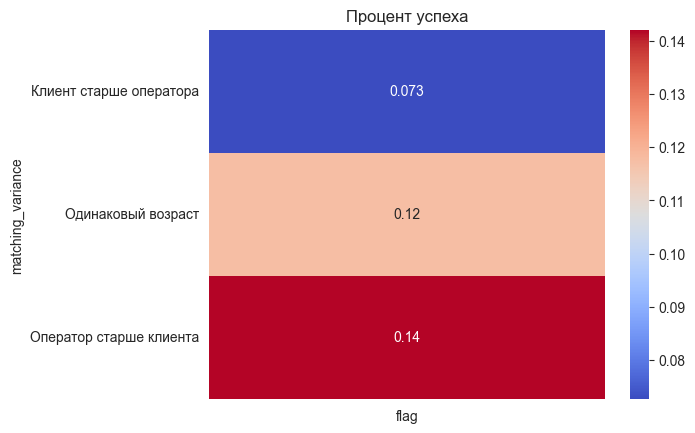

In [8]:
# Выделяю только кредитные карты
cc = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards'])].copy()

# создаю сводную таблицу, где строки - мэтчинг варианс,значение - средняя успешность для этих условий 
pivot = cc.pivot_table(index='matching_variance' , values='flag', aggfunc='mean')

# делаю хитмапу по сводной таблице, cmap - цвета, в которых делать
sns.heatmap(pivot, annot=True, cmap='coolwarm')

plt.title('Процент успеха')
plt.show()

ну эту хитмапу точно помнишь)